In [ ]:
# testing extended search area piv from pyprocess
# this won't show any difference since 0.23 version
# because we incorporate the extended_seach_piv
# 

In [2]:
import numpy as np
from numpy.fft import rfft2, irfft2, fftshift
from numpy import log
import matplotlib.pyplot as plt
from openpiv.tools import imread
from openpiv.pyprocess import extended_search_area_piv, \
                            moving_window_array, \
                            fft_correlate_strided_images, \
                            find_subpixel_peak_position, \
                            normalize_intensity, \
                            get_field_shape

In [3]:
frame_a = imread('../test1/exp1_001_a.bmp')
frame_b = imread('../test1/exp1_001_b.bmp')

In [4]:
# frame_a = frame_a[:128,:64]
# frame_b = frame_b[:128,:64]

In [5]:
def show_pair(I,J):
    fig, ax = plt.subplots(1,2,figsize=(12,8))
    ax[0].imshow(I,cmap=plt.cm.gray)
    ax[1].imshow(J,cmap=plt.cm.gray)

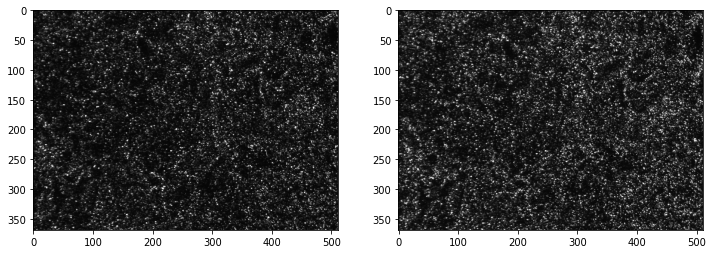

In [6]:
show_pair(frame_a, frame_b)

In [7]:
frame_a = normalize_intensity(frame_a)
frame_b = normalize_intensity(frame_b)


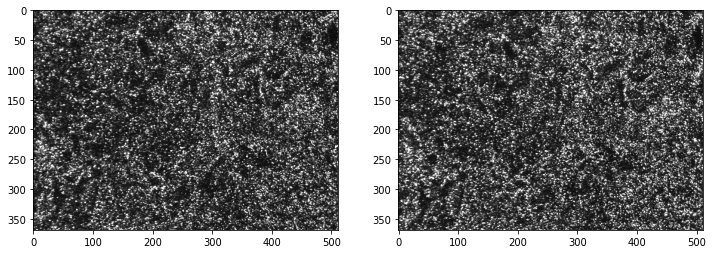

In [8]:
show_pair(frame_a, frame_b)

In [9]:
window_size = 32
overlap = 16
dt=1.0
search_area_size = 32
correlation_method="fft"
subpixel_method="gaussian"
sig2noise_method='peak2peak'

In [10]:
%%time
vel = extended_search_area_piv(frame_a, frame_b, window_size=window_size,
               search_area_size=search_area_size, overlap=overlap,dt=dt,
                               correlation_method=correlation_method,
                               subpixel_method=subpixel_method,
                               sig2noise_method=sig2noise_method)

CPU times: user 149 ms, sys: 44.2 ms, total: 193 ms
Wall time: 192 ms


In [11]:
%%time

aa = moving_window_array(frame_a, window_size, overlap)
bb = moving_window_array(frame_b, window_size, overlap)

c = fft_correlate_strided_images(aa,bb)

n_rows, n_cols = get_field_shape(frame_a.shape, search_area_size, overlap)

# iterate through interrogation widows and search areas
u1 = np.zeros((n_rows, n_cols))
v1 = np.zeros((n_rows, n_cols))

for k in range(n_rows):
    for m in range(n_cols):
        row, col = find_subpixel_peak_position(
            c[k*n_cols+m,:,:], subpixel_method=subpixel_method
        )

        row -= (search_area_size + window_size - 1) // 2
        col -= (search_area_size + window_size - 1) // 2

        # get displacements, apply coordinate system definition
        u1[k, m], v1[k, m] = -col, row

CPU times: user 86.9 ms, sys: 39.5 ms, total: 126 ms
Wall time: 125 ms


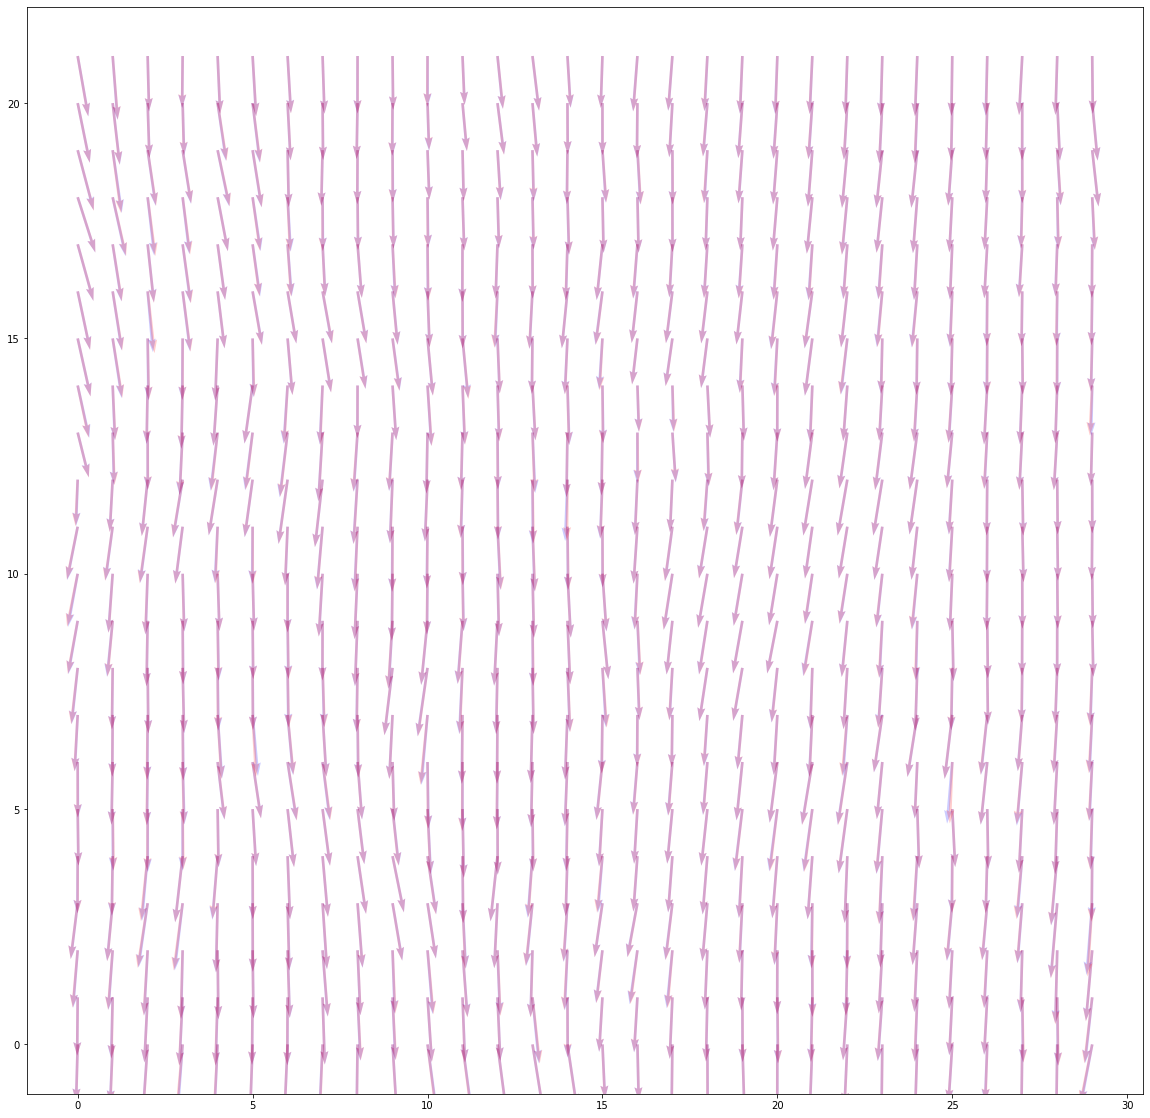

In [12]:
plt.figure(figsize=(20,20))
plt.quiver(vel[0],vel[1],scale=100,color='b',alpha=0.2)
plt.quiver(u1,v1,scale=100,color='r',alpha=0.2)